# Implementing the Partial Convolution Layer
One of the pillars of the paper is the partial convolution layer, which we'll have to implement in Keras. We'll base the new layer off the current Convolution2D layer already in Keras, and then introduce the mask, so that in our PConv2D layer a tuple of (img, mask) is passed, and a tuple of (conv_img, conv_mask) is returned

In [4]:
from copy import deepcopy
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

# Import modules from libs/ directory
from libs.pconv_layer import PConv2D
from libs.util import random_mask

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
??PConv2D

# Testing

## Load Data

Shape of image is: (639, 960, 3)


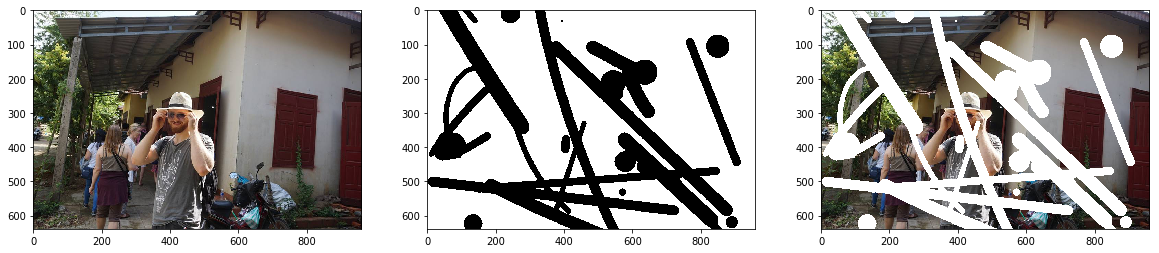

In [6]:
# Load image
img = cv2.imread('./data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 255

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Implement Model

In [7]:
# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])


# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 639, 960, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 639, 960, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 317, 477, 8) 1184        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
p_conv2d_2 (PConv2D)            [(None, 157, 237, 16 3216        p_conv2d_1[0][0]                 
          

## Check mask layer updates

In [8]:
formatted_img = np.expand_dims(masked_img, 0) / 255
formatted_mask = np.expand_dims(mask, 0)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

output_img, o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 639, 960, 3) - Max: 1


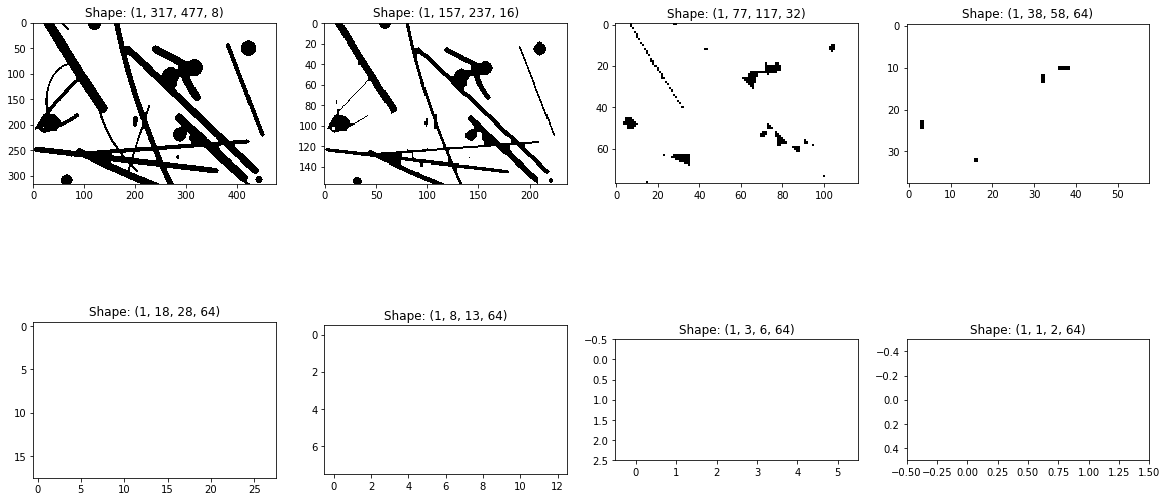

In [9]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

This looks exactly like it's supposed to - the further down we do in the network, the less significant the masking gets.